# Radiative-Convective Equilibrium with CAM3 scheme

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

##  Here is how to set a simple RCE in `climlab`

By initializing each component with the same state object, the components are already effectively coupled. They all act to modify the same state object.

No extra coupling code is necessary.

In [2]:
# initial state (temperatures)
state = climlab.column_state(num_lev=20, num_lat=1, water_depth=5.)

In [3]:
#  Create a parent process
rce = climlab.TimeDependentProcess(state=state)
## Create individual physical process models:
#  fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Hard convective adjustment
convadj = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
# CAM3 radiation with default parameters and interactive water vapor
rad = climlab.radiation.CAM3(state=state, specific_humidity=h2o.q)

# Couple the models
rce.add_subprocess('Radiation', rad)
rce.add_subprocess('ConvectiveAdjustment', convadj)
rce.add_subprocess('H2O', h2o)

Opened data from /home/phil/mini38/envs/clim37/lib/python3.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


In [4]:
print(rce)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (20,) 
The subprocess tree: 
Untitled: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.cam3.cam3.CAM3'>
   ConvectiveAdjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



In [5]:
#  Current state
rce.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.        , 204.10526316, 208.21052632, 212.31578947,
       216.42105263, 220.52631579, 224.63157895, 228.73684211,
       232.84210526, 236.94736842, 241.05263158, 245.15789474,
       249.26315789, 253.36842105, 257.47368421, 261.57894737,
       265.68421053, 269.78947368, 273.89473684, 278.        ])})

In [6]:
#  Integrate the model forward
rce.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.


Total elapsed time is 4.999422301147019 years.


In [7]:
#  Current state
rce.state

AttrDict({'Ts': Field([276.77058287]), 'Tatm': Field([233.26150428, 215.95044945, 210.60589023, 211.45113437,
       212.04321205, 216.46759988, 223.46187556, 229.6327028 ,
       235.16956012, 240.2017945 , 244.8218937 , 249.09842749,
       253.08373297, 256.81872305, 260.33602553, 263.66210602,
       266.81874721, 269.82410613, 272.69348696, 275.43991673])})

In [8]:
#  Current specific humidity
rce.q

Field([1.87420483e-05, 9.64556905e-06, 5.58553481e-06, 6.57792987e-06,
       7.30688198e-06, 1.30016777e-05, 3.02115363e-05, 6.04582768e-05,
       1.08656640e-04, 1.80140927e-04, 2.80533313e-04, 4.15636693e-04,
       5.91349145e-04, 8.13596531e-04, 1.08827995e-03, 1.42123518e-03,
       1.81820176e-03, 2.28479967e-03, 2.82651219e-03, 3.44867359e-03])

In [9]:
#  Here is the dictionary of input fields for the CAM3 radiation module
rce.subprocess.Radiation.input

{'specific_humidity': Field([1.87420483e-05, 9.64556905e-06, 5.58553481e-06, 6.57792987e-06,
        7.30688198e-06, 1.30016777e-05, 3.02115363e-05, 6.04582768e-05,
        1.08656640e-04, 1.80140927e-04, 2.80533313e-04, 4.15636693e-04,
        5.91349145e-04, 8.13596531e-04, 1.08827995e-03, 1.42123518e-03,
        1.81820176e-03, 2.28479967e-03, 2.82651219e-03, 3.44867359e-03]),
 'absorber_vmr': {'CO2': 0.000348,
  'CH4': 1.65e-06,
  'N2O': 3.06e-07,
  'O2': 0.21,
  'CFC11': 0.0,
  'CFC12': 0.0,
  'CFC22': 0.0,
  'CCL4': 0.0,
  'O3': array([5.38853507e-06, 9.86362297e-07, 3.46334801e-07, 1.90806332e-07,
         1.19700066e-07, 7.69083554e-08, 5.97316411e-08, 5.27011190e-08,
         4.80406196e-08, 4.44967931e-08, 4.18202246e-08, 3.99595858e-08,
         3.83838549e-08, 3.66179869e-08, 3.42885526e-08, 3.18505117e-08,
         2.93003951e-08, 2.69906527e-08, 2.49122466e-08, 2.28798533e-08])},
 'cldfrac': 0.0,
 'clwp': 0.0,
 'ciwp': 0.0,
 'r_liq': 0.0,
 'r_ice': 0.0,
 'emissivity': 1.0

## Latitudinally, seasonally varying RCE

In [10]:
# initial state (temperatures)
state2 = climlab.column_state(num_lev=20, num_lat=30, water_depth=10.)

In [11]:
#  Create a parent process
rcelat = climlab.TimeDependentProcess(state=state2)
## Create individual physical process models:
#  seasonal insolation
insol = climlab.radiation.DailyInsolation(domains=rcelat.Ts.domain)
#  fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state2)
#  Hard convective adjustment
convadj = climlab.convection.ConvectiveAdjustment(state=state2, adj_lapse_rate=6.5)
# CAM3 radiation with interactive insolation and interactive water vapor
rad = climlab.radiation.CAM3(state=state2, 
                             specific_humidity=h2o.q,
                             S0 = insol.S0,
                             insolation=insol.insolation,
                             coszen=insol.coszen)
# Add all subprocesses to the parent process
rcelat.add_subprocess('Insolation', insol)
rcelat.add_subprocess('Radiation', rad)
rcelat.add_subprocess('ConvectiveAdjustment', convadj)
rcelat.add_subprocess('H2O', h2o)

Opened data from /home/phil/mini38/envs/clim37/lib/python3.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


In [12]:
rcelat.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.


Total elapsed time is 4.999422301147019 years.


In [13]:
rcelat.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.


Total elapsed time is 5.9987591795252575 years.


In [14]:
def plot_temp_section(model, timeave=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if timeave:
        field = model.timeave['Tatm'].transpose()
    else:
        field = model.Tatm.transpose()
    cax = ax.contourf(model.lat, model.lev, field)
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    fig.colorbar(cax)

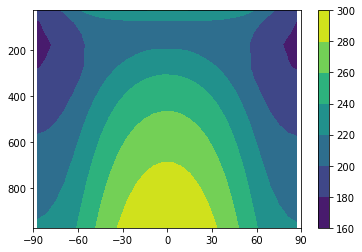

In [15]:
plot_temp_section(rcelat)

## Same thing, but also including meridional temperature diffusion

In [16]:
#  Create and exact clone of the previous model
diffmodel = climlab.process_like(rcelat)

In [17]:
# thermal diffusivity in W/m**2/degC
D = 0.05
# meridional diffusivity in 1/s
K = D / diffmodel.Tatm.domain.heat_capacity[0]
print(K)

9.760956175298806e-08


In [18]:
d = climlab.dynamics.MeridionalDiffusion(K=K, state={'Tatm': diffmodel.Tatm}, **diffmodel.param)

In [19]:
diffmodel.add_subprocess('diffusion', d)

In [20]:
diffmodel.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.


Total elapsed time is 10.998181480672276 years.


In [21]:
diffmodel.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.


Total elapsed time is 11.997518359050515 years.


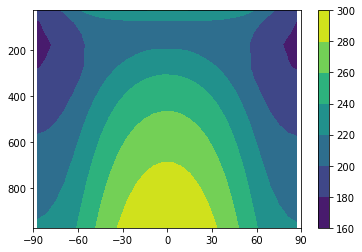

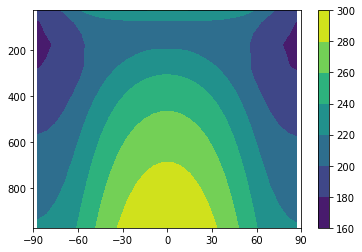

In [22]:
plot_temp_section(rcelat)
plot_temp_section(diffmodel)

In [23]:
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * np.math.pi * const.a**2 * integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )

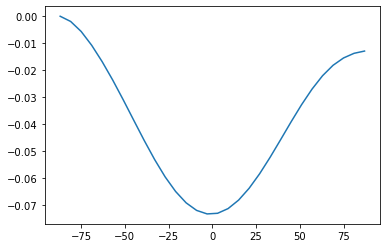

In [24]:
#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffmodel.timeave['ASR'] - diffmodel.timeave['OLR'])
plt.plot(diffmodel.lat, inferred_heat_transport(Rtoa, diffmodel.lat))

## If you want explicit surface fluxes...

All the models above use a convective adjustment that simultaneously adjustments `Tatm` and `Ts` to the prescribed lapse rate.

We can instead limit the convective adjustment to just the atmosphere. To do this, we just have to change the `state` variable dictionary in the convective adjustment process.

Then we can invoke process models for **sensible and latent heat fluxes** that use simple bulk formulae. Tunable parameters for these include drag coefficient and surface wind speed.

In [25]:
diffmodel2 = climlab.process_like(diffmodel)

#  Hard convective adjustment -- ATMOSPHERE ONLY
convadj2 = climlab.convection.ConvectiveAdjustment(state={'Tatm':diffmodel2.Tatm}, adj_lapse_rate=6.5)
diffmodel2.add_subprocess('ConvectiveAdjustment', convadj2)

print(diffmodel2)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (30, 1) 
  Tatm: (30, 20) 
The subprocess tree: 
Untitled: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   Radiation: <class 'climlab.radiation.cam3.cam3.CAM3'>
   ConvectiveAdjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>



In [26]:
#  Now add surface flux processes
#  Add surface heat fluxes

shf = climlab.surface.SensibleHeatFlux(state=diffmodel2.state, Cd=0.5E-3)
lhf = climlab.surface.LatentHeatFlux(state=diffmodel2.state, Cd=0.5E-3)
#  set the water vapor input field for LHF process
lhf.q = diffmodel2.subprocess['H2O'].q
diffmodel2.add_subprocess('SHF', shf)
diffmodel2.add_subprocess('LHF', lhf)

print(diffmodel2)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (30, 1) 
  Tatm: (30, 20) 
The subprocess tree: 
Untitled: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   Radiation: <class 'climlab.radiation.cam3.cam3.CAM3'>
   ConvectiveAdjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   diffusion: <class 'climlab.dynamics.meridional_advection_diffusion.MeridionalDiffusion'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>



In [27]:
diffmodel2.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.


Total elapsed time is 16.996940660197534 years.


In [28]:
diffmodel2.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.


Total elapsed time is 17.99627753857577 years.


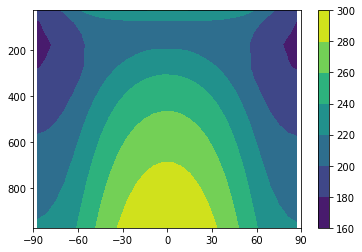

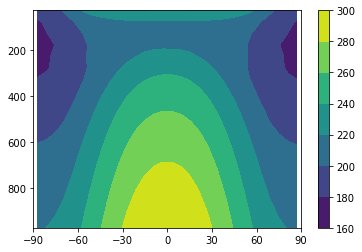

In [29]:
plot_temp_section(rcelat)
plot_temp_section(diffmodel2)

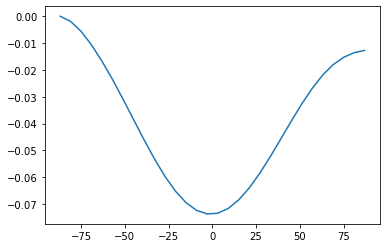

In [30]:
#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffmodel2.timeave['ASR'] - diffmodel2.timeave['OLR'])
plt.plot(diffmodel2.lat, inferred_heat_transport(Rtoa, diffmodel2.lat))